# Mapper on Fashion MNIST Data



In [3]:
import os
import hdbscan
import matplotlib.pyplot as plt
from mnist import MNIST
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import umap.umap_ as umap

import kmapper as km
from kmapper import jupyter
from kmapper import adapter

/home/amber/src/SteinhausNotebooks/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
%matplotlib inline
sns.set(style='white', context='poster')

save = False
save_root = "redo/images/"

In [6]:
classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

# Setup

We load in the dataset, and construct a training set and a test set.

In [7]:
mndata = MNIST('data/fashion')
# mndata.gz = True
train, train_labels = mndata.load_training()
test, test_labels = mndata.load_testing()
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.hstack([train_labels, test_labels])
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.1, random_state=42)

In [8]:
data_train.shape

(63000, 784)

### Reduce dimensionality of image space

Not really necessary, but can help the modeling in later steps.

In [9]:
p = PCA(n_components=100)
reduced_data_train = p.fit_transform(data_train)
reduced_data_test = p.transform(data_test)

# Train a Model

We use logistic regression to train a fashion classifier.

In [10]:
lr = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000)
%time lr.fit(reduced_data_train, target_train)

CPU times: user 4min 44s, sys: 178 ms, total: 4min 44s
Wall time: 4min 47s


LogisticRegression(max_iter=10000, penalty='l1', solver='liblinear')

In [11]:
lr.score(reduced_data_train, target_train), lr.score(reduced_data_test, target_test)

(0.848984126984127, 0.8424285714285714)

In [12]:
lens_train = lr.decision_function(reduced_data_train)

mapper_ids = np.array(list(range(len(lens_train)))) 
mapper_reduced_data = reduced_data_train[mapper_ids]
mapper_lens = lens_train[mapper_ids]
mapper_view_data = data_train[mapper_ids]
mapper_labels = target_train[mapper_ids]

mapper_lbls = [classes[i] for i in mapper_labels]

# Dimensionality reduction of prediction space

We compare using UMAP vs PCA for our Mapper lens.

In [13]:
u = umap.UMAP(n_neighbors=5)
lens = u.fit_transform(mapper_lens)

/home/amber/src/SteinhausNotebooks/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [14]:
lens2 = PCA(n_components=2).fit_transform(mapper_lens)

We plot the UMAP (left) and PCA (right) lens images.

In [15]:
model = lr

def reduced_scatter(lens, ax=None):
    ax = ax or plt.gca()
    
    plt.scatter(*lens.T, s=0.1, c=mapper_labels, cmap='Spectral', alpha=1.0)
    plt.setp(ax, xticks=[], yticks=[])
    cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
    cbar.set_ticks(np.arange(10))
    cbar.set_ticklabels(classes)

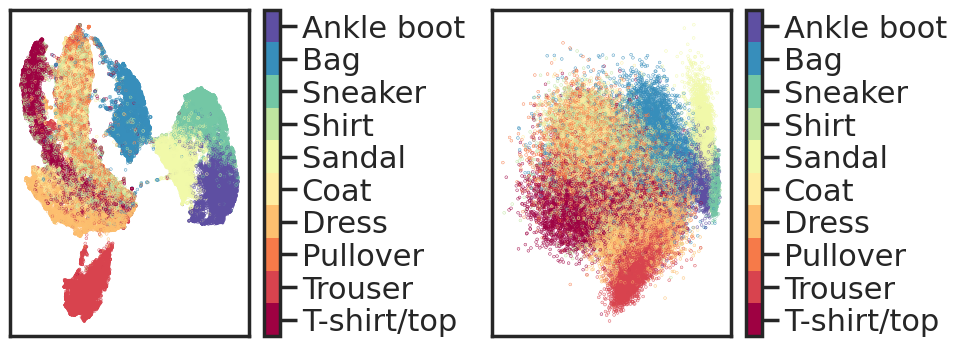

In [16]:
plt.figure(figsize=(10,4))
ax = plt.subplot(121)
reduced_scatter(lens, ax)

ax = plt.subplot(122)
reduced_scatter(lens2, ax)

plt.tight_layout()

# Construct Mapper Graph

We make use of Kepler Mapper to construct the mapper graph given by our lens function given by UMAP

In [17]:
lens2 = MinMaxScaler().fit_transform(lens)
graph = km.KeplerMapper(verbose=1).map(lens2, reduced_data_train,
                                       clusterer=km.cluster.DBSCAN(10),
                                       cover=km.Cover(n_cubes=40, perc_overlap=.5),
                                       nerve=km.GraphNerve(min_intersection=1))
# html = km.KeplerMapper().visualize(graph, color_function=mapper_labels)#, custom_tooltips=mapper_lbls)


KeplerMapper(verbose=1)
Mapping on data shaped (63000, 100) using lens shaped (63000, 2)

Creating 1600 hypercubes.

Created 3123 edges and 883 nodes in 0:00:08.078291.


## Plot the Mapper graph

We plot the Mapper graph coloring nodes by what class they represent.

In [19]:
nx_graph = adapter.to_networkx(graph)

small_components = [c for cc in nx.connected_components(nx_graph) for c in cc if len(cc) < 3]
nx_graph.remove_nodes_from(small_components)

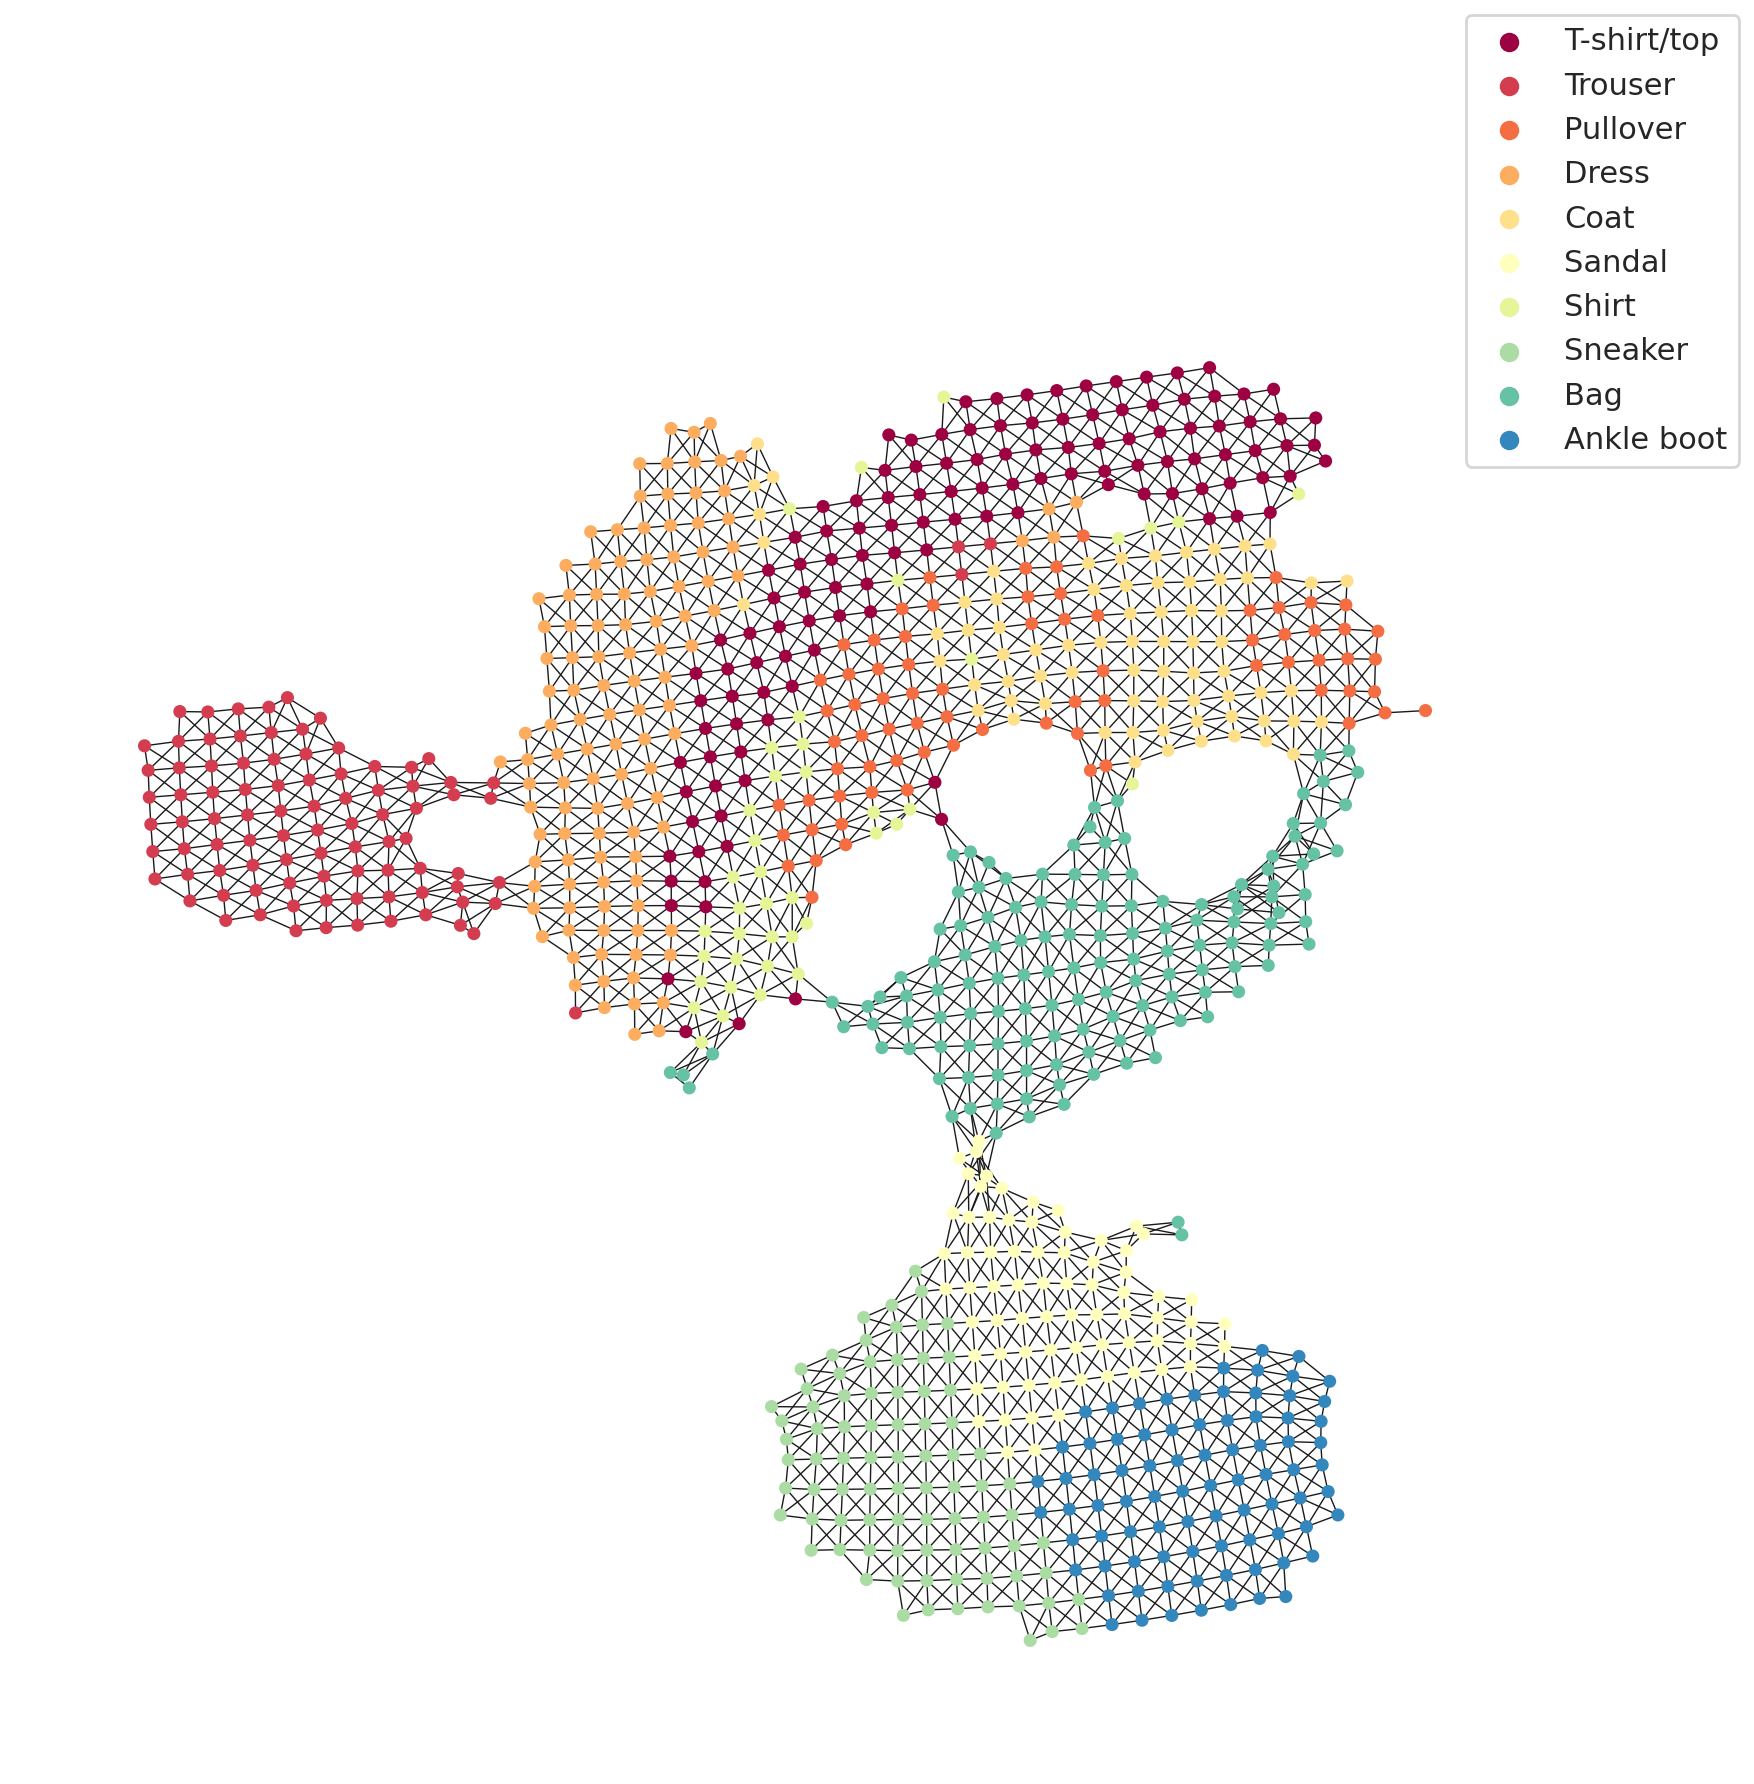

In [113]:
def visualize(cc_sub, pos=None):
    pos = pos or nx.drawing.kamada_kawai_layout(cc_sub)
    cmap = plt.cm.Spectral
    f, axarr = plt.subplots(1,1, figsize=(20,20))
    colors = []
    
    # Color each node based on which item is most represented
    for node in cc_sub.nodes():
        labels = [mapper_lbls[i] for i in graph['nodes'][node]]
        counts = np.array([labels.count(cls) for cls in classes])
        i = counts.argmax()
        colors.append(cmap(i / len(classes)))
    
    nx.draw(cc_sub, node_color=colors, pos=pos, node_size=55, with_labels=False, ax=axarr)
    for i, label in enumerate(classes):
        axarr.scatter([], [], c=[cmap(i / len(classes))], label=label)
        
    f.legend()
        
visualize(nx_graph)


# Find the stable path between two nodes

In [55]:
start = "cube372_cluster0"
end = "cube138_cluster0"

Construct the edge weights given by the Jaccard distance:

In [76]:
# Get the members that lie in the intersection of two covers
edge_members = {}
for start, ends in graph['links'].items():
    for end in ends:
        members = set(nx_graph.nodes[start]['membership']).intersection(nx_graph.nodes[end]['membership'])
        edge_members[(start, end)] = list(members)
        
nx.set_edge_attributes(nx_graph, edge_members, "membership")

# Compute the edge weights
edge_jd = {}

for edge in nx_graph.edges:
    left = nx_graph.nodes[edge[0]]['membership']
    right = nx_graph.nodes[edge[1]]['membership']
    jd = 1 - set(left).intersection(set(right)).__len__() / set(left).union(set(right)).__len__()
    edge_jd[edge] = jd

nx.set_edge_attributes(G=nx_graph, name='dist', values=edge_jd)

Find the stable paths and draw the most stable.

TypeError: draw_networkx_edges() got an unexpected keyword argument 'linewidth'

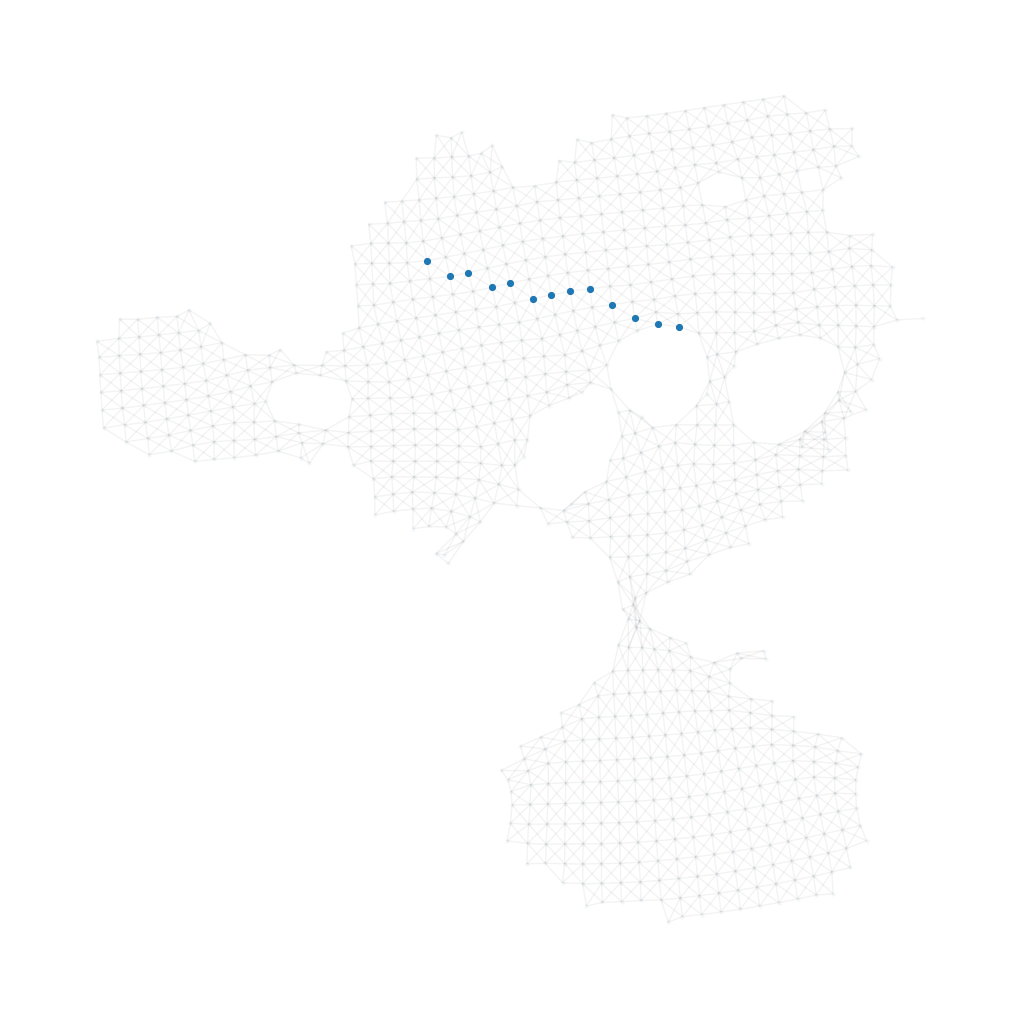

In [61]:
import paths
most_stable, all_stable_paths = paths.most_stable_paths(nx_graph, start, end)
paths.draw.draw_stable_paths(nx_graph, most_stable, start, end)

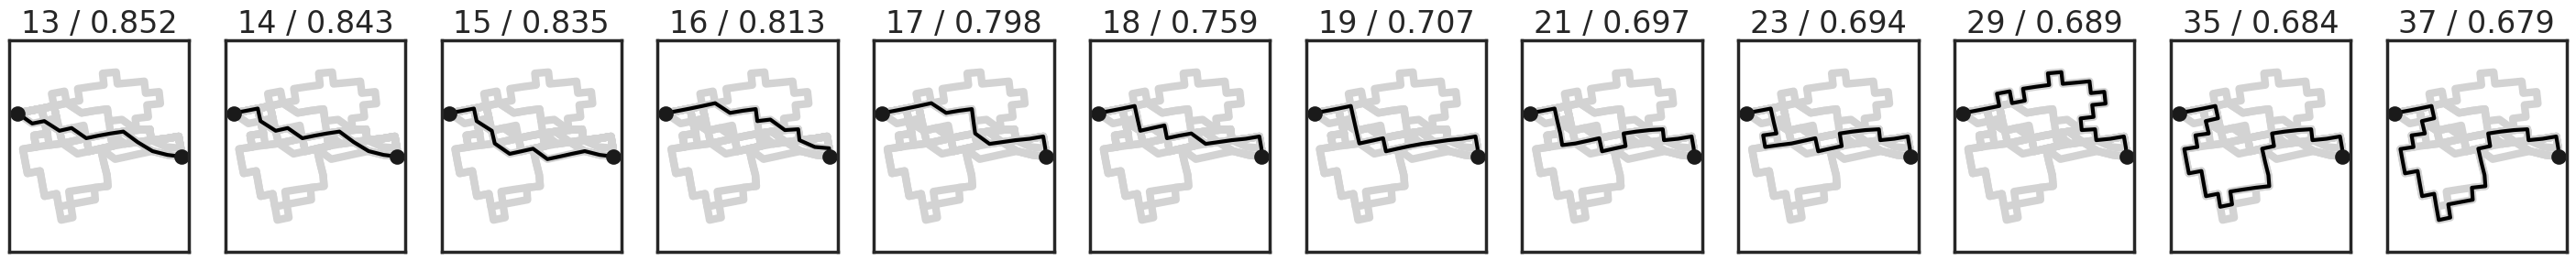

In [63]:
paths.draw.draw_multiples(nx_graph, most_stable)

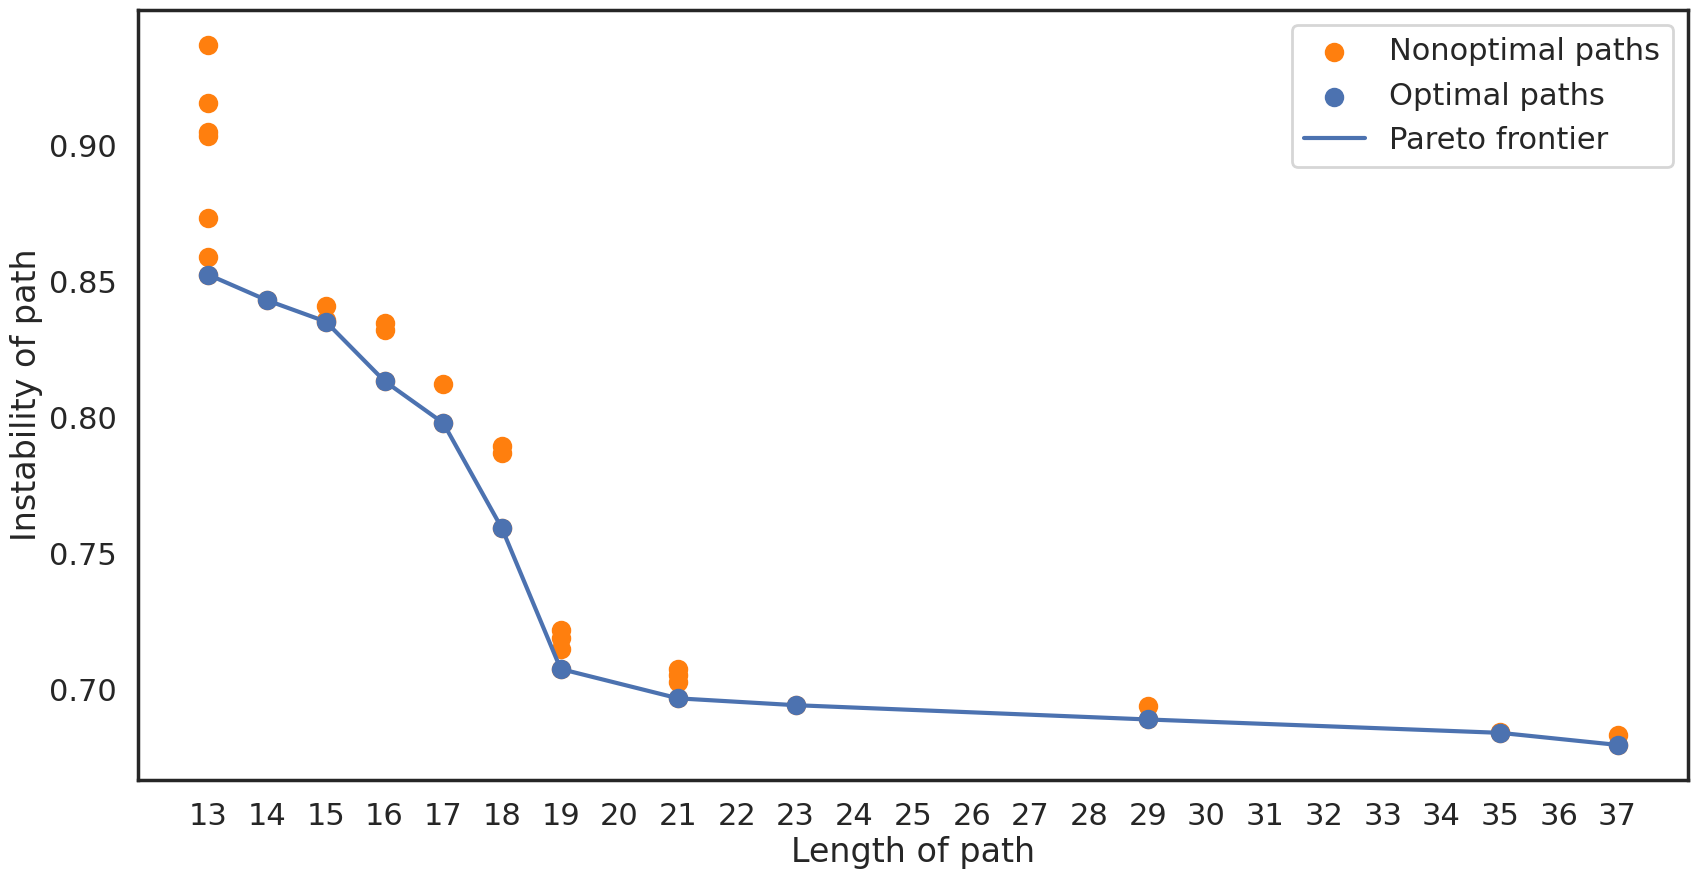

In [64]:
# plt.figure(figsize=(20,8))
paths.draw.plot_pareto(most_stable, all_stable_paths)

# Print the stable path 

In [115]:
def print_path(p):
    for j, node in enumerate(p):
        labels = [mapper_lbls[i] for i in graph['nodes'][node]]
        counts = { cls: labels.count(cls) for cls in classes if labels.count(cls) > 0 }
        print("{}. {}".format(j+1, counts))

print_path(most_stable[37][0])

1. {'T-shirt/top': 2, 'Pullover': 73, 'Dress': 3, 'Coat': 61, 'Shirt': 46}
2. {'T-shirt/top': 11, 'Trouser': 1, 'Pullover': 191, 'Dress': 10, 'Coat': 220, 'Shirt': 119, 'Bag': 1}
3. {'T-shirt/top': 12, 'Trouser': 1, 'Pullover': 239, 'Dress': 8, 'Coat': 357, 'Shirt': 161, 'Bag': 4}
4. {'T-shirt/top': 7, 'Trouser': 1, 'Pullover': 207, 'Dress': 6, 'Coat': 361, 'Shirt': 177, 'Bag': 5}
5. {'T-shirt/top': 8, 'Trouser': 2, 'Pullover': 250, 'Dress': 9, 'Coat': 254, 'Shirt': 153, 'Bag': 3}
6. {'T-shirt/top': 5, 'Trouser': 1, 'Pullover': 170, 'Dress': 12, 'Coat': 184, 'Shirt': 186, 'Bag': 4}
7. {'T-shirt/top': 20, 'Trouser': 1, 'Pullover': 197, 'Dress': 30, 'Coat': 211, 'Shirt': 147, 'Bag': 5}
8. {'T-shirt/top': 20, 'Pullover': 210, 'Dress': 29, 'Coat': 207, 'Shirt': 148, 'Bag': 4}
9. {'T-shirt/top': 5, 'Pullover': 190, 'Dress': 12, 'Coat': 135, 'Shirt': 131, 'Bag': 2}
10. {'T-shirt/top': 6, 'Trouser': 1, 'Pullover': 268, 'Dress': 21, 'Coat': 165, 'Shirt': 207, 'Bag': 2}
11. {'T-shirt/top': 10, 